# AutoGluon Time Series - Forecasting In-depth
In this notebook we will discuss the advanced functionality of AutoGluon's `timeseries` module.

We will use these features to build a demand forecasting model for grocery sales.

This tutorial assumes that you have already completed the [Forecasting Essentials](01-forecasting-essentials.ipynb) notebook.

In [1]:
!pip install -q uv
# Use CPU version of PyTorch for faster installation
!uv pip install torch==2.5 torchvision --index-url https://download.pytorch.org/whl/cpu
!uv pip install autogluon==1.2

Using Python 3.10.15 environment at: /home/ec2-user/anaconda3/envs/python3
Audited 2 packages in 12ms
Using Python 3.10.15 environment at: /home/ec2-user/anaconda3/envs/python3
Audited 1 package in 29ms


In [2]:
import matplotlib.pyplot as plt  # for plotting only
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

## Forecasting time series with additional information
In real-world forecasting problems we often have access to additional information, beyond just the historic time series values.
AutoGluon supports two types of such additional information: static features and time-varying covariates.

### Static features
Static features are the time-independent attributes (metadata) of a time series.
These may include information such as:

- location, where the time series was recorded (country, state, city)
- fixed properties of a product (brand name, color, size, weight)
- store ID or product ID

Providing this information may, for instance, help forecasting models generate similar demand forecasts for stores located in the same city.

### Time-varying covariates
Covariates are the time-varying features that may influence the target time series.
They are sometimes also referred to as dynamic features, exogenous regressors, or related time series.
AutoGluon supports two types of covariates:

- *known* covariates that are known for the entire forecast horizon, such as
    - holidays
    - day of the week, month, year
    - promotions

- *past* covariates that are only known up to the start of the forecast horizon, such as
    - sales of other products
    - temperature, precipitation
    - transformed target time series


![Target time series with one past covariate and one known covariate.](https://autogluon-timeseries-datasets.s3.us-west-2.amazonaws.com/public/figures/forecasting-indepth5.png)

In AutoGluon, both `known_covariates` and `past_covariates` are stored as additional columns in the `TimeSeriesDataFrame`.


### Example: Grocery sales data
For example, let's have a look at the grocery sales dataset. The dataset contains weekly sales data for various food items sold at different stores.


In [3]:
df = pd.read_csv("https://autogluon.s3.us-west-2.amazonaws.com/datasets/timeseries/grocery_sales/test.csv")
df

,item_id,timestamp,scaled_price,promotion_email,promotion_homepage,unit_sales
0,1062_101,2018-01-01,0.879130,0.0,0.0,636.0
1,1062_101,2018-01-08,0.994517,0.0,0.0,123.0
2,1062_101,2018-01-15,1.005513,0.0,0.0,391.0
3,1062_101,2018-01-22,1.000000,0.0,0.0,339.0
4,1062_101,2018-01-29,0.883309,0.0,0.0,661.0
...,...,...,...,...,...,...
9884,2956_108,2018-07-02,1.001721,0.0,0.0,15.0
9885,2956_108,2018-07-09,0.998282,0.0,0.0,67.0
9886,2956_108,2018-07-16,0.996570,0.0,0.0,82.0
9887,2956_108,2018-07-23,1.000000,0.0,0.0,96.0


As usual, `item_id` contains the unique identifier of each time series and `timestamp` contains the timestamps of the observations.
The `unit_sales` column is the target time series that we want to forecast.

We will use the remaining columns as the time-varying covariates:
- `scaled_price` - scaled price of each product on the given week
- `promotion_email`, `promotion_homepage` - binary indicators that show whether the product was promoted in an email / on the homepage during the given week

In [4]:
df.describe().round(2)

,scaled_price,promotion_email,promotion_homepage,unit_sales
count,9175.00,9175.00,9175.00,9175.00
mean,0.94,0.08,0.14,275.81
std,0.11,0.27,0.34,396.23
min,0.32,0.00,0.00,13.00
25%,0.90,0.00,0.00,54.00
50%,1.00,0.00,0.00,150.00
75%,1.00,0.00,0.00,364.00
max,1.28,1.00,1.00,10544.00


Now we load an additional table containing the static (time-independent) features of the time series.

In [5]:
static_df = pd.read_csv("https://autogluon.s3.us-west-2.amazonaws.com/datasets/timeseries/grocery_sales/static.csv")
static_df

,item_id,product_code,product_category,product_subcategory,location_code
0,1062_101,1062,Beverages,Fruit Juice Mango,101
1,1062_102,1062,Beverages,Fruit Juice Mango,102
2,1062_104,1062,Beverages,Fruit Juice Mango,104
3,1062_106,1062,Beverages,Fruit Juice Mango,106
4,1062_108,1062,Beverages,Fruit Juice Mango,108
...,...,...,...,...,...
314,2867_106,2867,Beef,Ground Beef,106
315,2867_108,2867,Beef,Ground Beef,108
316,2867_110,2867,Beef,Ground Beef,110
317,2956_104,2956,Vegetable,Potato,104


This table contains the time-independent attributes of each time series, indicating the type of the product and the location code of the store where it is sold.

------

We need to convert the data into a `TimeSeriesDataFrame` to use it in AutoGluon.

In [6]:
full_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp",
    static_features_df=static_df,
)

The `TimeSeriesDataFrame` that we created now holds both the dynamic and the static features of the dataset.

In [7]:
full_data.head()

scaled_price  promotion_email  promotion_homepage  \
item_id  timestamp                                                       
1062_101 2018-01-01      0.879130              0.0                 0.0   
         2018-01-08      0.994517              0.0                 0.0   
         2018-01-15      1.005513              0.0                 0.0   
         2018-01-22      1.000000              0.0                 0.0   
         2018-01-29      0.883309              0.0                 0.0   

                     unit_sales  
item_id  timestamp               
1062_101 2018-01-01       636.0  
         2018-01-08       123.0  
         2018-01-15       391.0  
         2018-01-22       339.0  
         2018-01-29       661.0

In [8]:
full_data.static_features.head()

,product_code,product_category,product_subcategory,location_code
item_id,,,,
1062_101,1062,Beverages,Fruit Juice Mango,101
1062_102,1062,Beverages,Fruit Juice Mango,102
1062_104,1062,Beverages,Fruit Juice Mango,104
1062_106,1062,Beverages,Fruit Juice Mango,106
1062_108,1062,Beverages,Fruit Juice Mango,108


### Train-test split
Currently, `full_data` contains all the available historic sales data. We will use the last 4 weeks of observations as a **test set** (not used during training) to measure the performance of the trained predictor.

This is very important to get a fair estimate of the performance. If we compute the scores on the same data as we used for training, our results would be overly optimistic - the predictor could have "memorized" the training data in a way that does not generalize into the future.

In [9]:
prediction_length = 4  # we will forecast 4 weeks into the future
train_data, test_data = full_data.train_test_split(prediction_length=prediction_length)

In [10]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="unit_sales",
)
predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit=120,
)

Beginning AutoGluon training... Time limit = 120s
AutoGluon will save models to '/home/ec2-user/SageMaker/awsreinvent2024/Session-OPN302/2024-reinvent/timeseries/AutogluonModels/ag-20241204_003651'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.15
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 23 17:17:00 UTC 2024
CPU Count:          16
GPU Count:          0
Memory Avail:       54.16 GB / 61.79 GB (87.7%)
Disk Space Avail:   74.14 GB / 78.56 GB (94.4%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 4,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'unit_sales',
 'time_limit': 120,
 'verbosity': 2}


Now, we evaluate the trained models on the held-out test data.

In [11]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.316770,-0.302612,0.926833,0.805701,0.723972,9
1,Chronos[bolt_small],-0.320658,-0.303438,0.578104,0.535595,1.451331,7
2,TemporalFusionTransformer,-0.328081,-0.335699,0.246585,0.187940,43.889862,8
3,DirectTabular,-0.337625,-0.346773,0.099775,0.082166,2.416646,4
4,Theta,-0.408249,-0.393971,0.249190,14.266235,0.043752,6
5,ETS,-0.441502,-0.430080,0.261782,0.748296,0.043404,5
6,SeasonalNaive,-0.477211,-0.628286,0.223703,0.221469,0.020182,2
7,Naive,-0.477211,-0.628286,0.247069,1.229502,0.021012,1
8,RecursiveTabular,-0.532370,-0.582461,0.087183,0.083088,0.655550,3


Let's have a closer look at the predictor logs to understand how it interpreted the different features.
```
...
Provided data contains following columns:
	target: 'unit_sales'
	past_covariates:
		categorical:        []
		continuous (float): ['scaled_price', 'promotion_email', 'promotion_homepage']
	static_features:
		categorical:        ['product_category', 'product_subcategory']
		continuous (float): ['product_code', 'location_code']
...
```
We notice a few problems here.

First, the columns `'scaled_price'`, `'promotion_email'` and `'promotion_homepage'` were used as past covariates, even though we know these columns in advance (we decide how to set the price or whether to run a promotion). 

To fix this problem, we need to explicitly state that these columns are known using the `known_covariates_names` argument when creating the predictor.

In [12]:
predictor_fixed = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="unit_sales",
    known_covariates_names=["scaled_price", "promotion_email", "promotion_homepage"],
)

The second problem is that the static features `product_code` and `location_code` (originally of integer type) are interpreted as continuous attributes, even though they are meant to be used as categorical features.

To fix this problem, we need to explicitly set their type to `"category"`.

In [13]:
train_data.static_features["product_code"] = train_data.static_features["product_code"].astype("category")
train_data.static_features["location_code"] = train_data.static_features["location_code"].astype("category")

Now let's train the new predictor after we fixed the data issues.

In [14]:
predictor_fixed.fit(train_data, presets="medium_quality", time_limit=120)

Beginning AutoGluon training... Time limit = 120s
AutoGluon will save models to '/home/ec2-user/SageMaker/awsreinvent2024/Session-OPN302/2024-reinvent/timeseries/AutogluonModels/ag-20241204_003802'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.15
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 23 17:17:00 UTC 2024
CPU Count:          16
GPU Count:          0
Memory Avail:       51.59 GB / 61.79 GB (83.5%)
Disk Space Avail:   74.13 GB / 78.56 GB (94.4%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': 'light',
 'known_covariates_names': ['scaled_price',
                            'promotion_email',
                            'promotion_homepage'],
 'num_val_windows': 1,
 'prediction_length': 4,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'ref

In [15]:
predictor_fixed.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.249517,-0.252793,0.887501,0.918340,0.713131,9
1,DirectTabular,-0.253513,-0.257834,0.102607,0.098982,3.439054,4
2,Chronos[bolt_small],-0.320658,-0.303438,0.547357,0.571538,0.027035,7
3,TemporalFusionTransformer,-0.406214,-0.408025,0.270564,0.188759,51.332612,8
4,Theta,-0.408249,-0.393971,0.235123,0.247819,0.047191,6
5,RecursiveTabular,-0.428835,-0.432352,0.108919,0.097366,0.869010,3
6,ETS,-0.441502,-0.430080,0.261167,0.260408,0.046356,5
7,SeasonalNaive,-0.477211,-0.628286,0.217115,0.210115,0.024760,2
8,Naive,-0.477211,-0.628286,0.242917,0.206043,0.024918,1


### Predicting with known covariates
When creating the predictor, we said that columns listed under `known_covariates` will be known in the future.
Therefore, when we call `predict`, we need to provide the future values of these columns.

The `known_covariates` must contain information for the `prediction_length` following the last observations in `train_data`

In [16]:
train_data.tail()

scaled_price  promotion_email  promotion_homepage  \
item_id  timestamp                                                       
2956_108 2018-06-04      1.000000              0.0                 0.0   
         2018-06-11      0.998285              0.0                 0.0   
         2018-06-18      1.001718              0.0                 0.0   
         2018-06-25      1.001721              0.0                 0.0   
         2018-07-02      1.001721              0.0                 0.0   

                     unit_sales  
item_id  timestamp               
2956_108 2018-06-04       108.0  
         2018-06-11       107.0  
         2018-06-18        80.0  
         2018-06-25        80.0  
         2018-07-02        15.0

We can get this information by selecting the necessary columns from the test data that we set aside before.

In [17]:
future_data = test_data.slice_by_timestep(-prediction_length, None)  # select the last prediction_length values of each time series
known_covariates = future_data.drop(columns=[predictor.target])
known_covariates.head()

scaled_price  promotion_email  promotion_homepage
item_id  timestamp                                                    
1062_101 2018-07-09      1.000000              0.0                 0.0
         2018-07-16      1.000000              0.0                 0.0
         2018-07-23      1.012346              0.0                 0.0
         2018-07-30      1.006248              0.0                 0.0
1062_102 2018-07-09      0.888134              0.0                 0.0

In [18]:
predictions = predictor.predict(train_data, known_covariates=known_covariates)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id  timestamp                                                    
1062_101 2018-07-09  356.695129  199.409714  251.771576  289.232117   
         2018-07-16  357.239044  176.631714  234.614807  277.866211   
         2018-07-23  349.137848  157.240448  218.314865  264.343079   
         2018-07-30  347.012360  146.824783  210.550400  257.934143   
1062_102 2018-07-09  230.990417  119.166924  149.036057  175.080200   

                            0.4         0.5         0.6         0.7  \
item_id  timestamp                                                    
1062_101 2018-07-09  324.880493  356.695129  389.464508  426.543030   
         2018-07-16  319.405792  357.239044  396.005768  439.323120   
         2018-07-23  308.277649  349.137848  390.985443  436.883545   
         2018-07-30  303.958008  347.012360  391.176788  440.294067   
1062_102 2018-07-09  203.587296  230.990417  259.854523  291.770264   

                            0.8         0.9  
item_id  timestamp                           
1062_101 2018-07-09  471.337433  542.651794  
         2018-07-16  492.216888  575.673096  
         2018-07-23  493.782104  583.426941  
         2018-07-30  499.432983  592.523560  
1062_102 2018-07-09  331.429749  393.908020

### Feature importance

We see that the new predictor with `known_covariates` achieves a much better test score than before!

This means that the features are quite important for improving the forecast accuracy. But which ones are the most important here? 

We can answer this question using the `feature_importance()` method.

In [19]:
feat_importance = predictor_fixed.feature_importance(test_data)
feat_importance.sort_values(by="importance", ascending=False)

Computing feature importance


,importance,stdev,n,p99_low,p99_high
scaled_price,0.044935,0.021416,5.0,0.000840,0.089030
product_code,0.016738,0.010628,5.0,-0.005145,0.038620
promotion_email,0.009059,0.012801,5.0,-0.017300,0.035417
promotion_homepage,0.001681,0.006367,5.0,-0.011428,0.014790
location_code,0.000761,0.000519,5.0,-0.000307,0.001829
product_category,0.000231,0.000319,5.0,-0.000427,0.000888
product_subcategory,0.000000,0.000000,0.0,NaN,NaN


We see that `scaled_price` and `product_code` are the most informative features in this dataset, and removing them would result in a significant drop in accuracy.

For more information on how the feature importance algorithm works in AutoGluon, check out the [documentation page](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.feature_importance.html).

## Challenge: Investigate the effect of the `eval_metric`
Now let's put our knowledge to practice to better understand how AutoGluon works.

In this challenge, you need to complete the following steps:
1. Train two predictors
    - one with `eval_metric="SQL"` ([scaled quantile loss](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-metrics.html#autogluon.timeseries.metrics.SQL)), an evaluation metric for probabilistic forecasts
    - another with `eval_metric="RMSE"` ([root mean squared error](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-metrics.html#autogluon.timeseries.metrics.RMSE)), an evaluation metric for point forecasts
2. Compute the `SQL` and `RMSE` metrics on the `test_data` for both predictors.

In [20]:
# Your code here

If you don't feel like writing the code yourself, click on the next section to reveal one possible implementation.

### Challenge solution

In [21]:
metrics = ["SQL", "RMSE"]
predictor_for_metric = {}
for metric in metrics:
    predictor_for_metric[metric] = TimeSeriesPredictor(
        prediction_length=prediction_length,
        target="unit_sales",
        known_covariates_names=["scaled_price", "promotion_email", "promotion_homepage"],
        eval_metric=metric,
        path=f"predictor-{metric}",
    ).fit(train_data, presets="medium_quality", time_limit=120)

Beginning AutoGluon training... Time limit = 120s
AutoGluon will save models to '/home/ec2-user/SageMaker/awsreinvent2024/Session-OPN302/2024-reinvent/timeseries/predictor-SQL'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.15
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 23 17:17:00 UTC 2024
CPU Count:          16
GPU Count:          0
Memory Avail:       51.58 GB / 61.79 GB (83.5%)
Disk Space Avail:   74.12 GB / 78.56 GB (94.3%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': SQL,
 'hyperparameters': 'light',
 'known_covariates_names': ['scaled_price',
                            'promotion_email',
                            'promotion_homepage'],
 'num_val_windows': 1,
 'prediction_length': 4,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'sk

In [22]:
for metric in metrics:
    scores = predictor_for_metric[metric].evaluate(test_data, metrics=metrics)
    print(f"Predictor trained with `eval_metric='{metric}'`: {scores}")

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


Predictor trained with `eval_metric='SQL'`: {'SQL': -0.6486127355786652, 'RMSE': -216.55198740879197}
Predictor trained with `eval_metric='RMSE'`: {'SQL': -0.7116893455277861, 'RMSE': -204.71037517316807}


### Discussion
We can observe that the predictor trained with the `SQL` metric achieves better `SQL` on the test set. Similarly, the predictor trained with `RMSE` achieves better `RMSE` on the test set.

When fitting `WeightedEnsemble`, AutoGluon looks for the combination of models that optimizes the chosen `eval_metric`. Not surprisingly, different models are selected when different metrics are used to measure accuracy. The resulting ensembles are tailored specifically to the metrics that they were trained with.


## Advanced configuration options

### Basic configuration with `presets` and `time_limit`
We can fit `TimeSeriesPredictor` with different pre-defined configurations using the `presets` argument of the `fit` method.

```python
predictor = TimeSeriesPredictor(...)
predictor.fit(train_data, presets="medium_quality")
```

Higher quality presets usually result in better forecasts but take longer to train.
The following presets are available:

| Preset         | Description                                          | Use Cases                                                                                                                                               | Fit Time (Ideal) | 
| :------------- | :----------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------ | :--------------- | 
| `fast_training`  | Fit simple statistical and baseline models + fast tree-based models   | Fast to train but may not be very accurate   |  0.5x |
| `medium_quality` | Same models as in `fast_training` + deep learning model `TemporalFusionTransformer`           | Good forecasts with reasonable training time         | 1x             |
| `high_quality`   | More powerful deep learning, machine learning, and statistical forecasting models   | Much more accurate than ``medium_quality``, but takes longer to train | 3x |
| `best_quality`   | Same models as in `high_quality`, more cross-validation windows | Typically more accurate than `high_quality`, especially for datasets with few (<50) time series | 6x             |

You can find more information about the [presets](https://github.com/autogluon/autogluon/blob/stable/timeseries/src/autogluon/timeseries/configs/presets_configs.py) and the [models includes in each preset](https://github.com/autogluon/autogluon/blob/stable/timeseries/src/autogluon/timeseries/models/presets.py#L109) in the AutoGluon source code.

Another way to control the training time is using the `time_limit` argument.

```python
predictor.fit(
    train_data,
    time_limit=60 * 60,  # total training time in seconds
)
```

If no `time_limit` is provided, the predictor will train until all models have been fit.


### Manually configuring models
Advanced users can override the presets and manually specify what models should be trained by the predictor using the `hyperparameters` argument.

```python
predictor = TimeSeriesPredictor(...)

predictor.fit(
    ...
    hyperparameters={
        "DeepAR": {},
        "Theta": [
            {"decomposition_type": "additive"},
            {"seasonal_period": 1},
        ],
    }
)
```

The above example will train three models:

* ``DeepAR`` with default hyperparameters
* ``Theta`` with additive seasonal decomposition (all other parameters set to their defaults)
* ``Theta`` with seasonality disabled (all other parameters set to their defaults)

You can also exclude certain models from the presets using the `excluded_model_type` argument.
```python
predictor.fit(
    ...
    presets="high_quality",
    excluded_model_types=["AutoETS", "AutoARIMA"],
)
```

For the full list of available models and the respective hyperparameters, see [Forecasting Model Zoo](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-model-zoo.html).

## Chronos - a foundation model for time series forecsating
AutoGluon-TimeSeries (AG-TS) includes [Chronos](https://github.com/amazon-science/chronos-forecasting) family of forecasting models. Chronos models are pretrained on a large collection of real & synthetic time series data, which enables them to make accurate forecasts on new data out of the box.

AG-TS provides a robust and easy way to use Chronos through the familiar `TimeSeriesPredictor` API.

### Getting started with Chronos

Being a pretrained model for zero-shot forecasting, Chronos is different from other models available in AG-TS. 
Specifically, Chronos models do not really `fit` time series data. However, when `predict` is called, they carry out a relatively more expensive computation that scales linearly with the number of time series in the dataset. In this aspect, they behave like local statistical models such as ETS or ARIMA, where all computation happens during inference. 

AutoGluon supports both the original Chronos models (e.g., [`chronos-t5-large`](https://huggingface.co/autogluon/chronos-t5-large)), as well as the new, more accurate and up to 250x faster Chronos-Bolt⚡ models (e.g., [`chronos-bolt-base`](https://huggingface.co/autogluon/chronos-bolt-base)). 

The easiest way to get started with Chronos is through the model-specific presets. 

- **(recommended)** The new, fast Chronos-Bolt️ models can be accessed using the `"bolt_tiny"`, `"bolt_mini"`, `"bolt_small"` and `"bolt_base"` presets.
- The original Chronos models can be accessed using the `"chronos_tiny"`, `"chronos_mini"`, `"chronos_small"`, `"chronos_base"` and `"chronos_large"` presets.

Note that the original Chronos models of size `small` and above require a GPU to run, while all Chronos-Bolt models can be run both on a CPU and a GPU.

Alternatively, Chronos can be combined with other time series models using presets `"medium_quality"`, `"high_quality"` and `"best_quality"`. More details about these presets are available in the documentation for [`TimeSeriesPredictor.fit`](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.fit.html).

### Zero-shot forecasting with Chronos
We create the [TimeSeriesPredictor](https://auto.gluon.ai/stable/api/autogluon.timeseries.TimeSeriesPredictor.html) and select the `"bolt_small"` presets to use the Chronos-Bolt (Small, 48M) model in zero-shot mode.

In [23]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="unit_sales",
).fit(
    train_data,
    presets="bolt_small",
)

Beginning AutoGluon training...
AutoGluon will save models to '/home/ec2-user/SageMaker/awsreinvent2024/Session-OPN302/2024-reinvent/timeseries/AutogluonModels/ag-20241204_004109'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.15
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 23 17:17:00 UTC 2024
CPU Count:          16
GPU Count:          0
Memory Avail:       53.71 GB / 61.79 GB (86.9%)
Disk Space Avail:   74.11 GB / 78.56 GB (94.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 4,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'unit_sales',
 'verbosity': 2}

Inferred

As promised, Chronos does not take any time to `fit`. The `fit` call merely serves as a proxy for the `TimeSeriesPredictor` to do some of its chores under the hood, such as inferring the frequency of time series and saving the predictor's state to disk. 

Let's use the `predict` method to generate forecasts, and the `plot` method to visualize them.

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


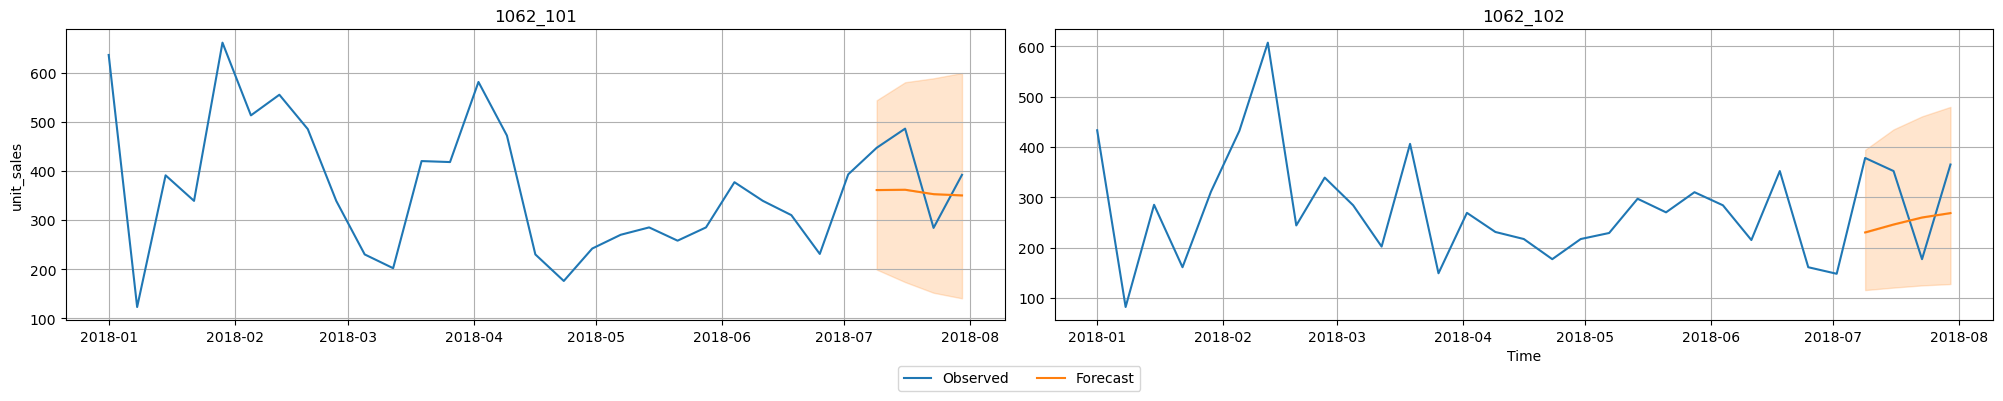

In [24]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=test_data,
    predictions=predictions,
    item_ids=test_data.item_ids[:2],  # plot first two items
);
plt.show()

In the above example we used Chronos for zero-shot forecasting. In this mode, the pretrained model is used to directly generate predictions on new data out of the box. This is the simplest and fastest way to generate predictions with Chronos.

In several [independent evaluations](https://arxiv.org/abs/2403.07815) we found Chronos to be effective in zero-shot forecasting. 
The accuracy of Chronos-Bolt (base) often exceeds statistical baseline models, and is often comparable to deep learning  models such as `TemporalFusionTransformer` or `PatchTST`.

### Beyond zero-shot forecasting

In addition to zero-shot forecasting, AutoGluon provides advanced features that can improve the accuracy of Chronos models:
- **Fine-tuning** Chronos models on custom data to improve the accuracy
- Handling **covariates & static features** by combining Chronos with a tabular regression model

You can learn more about these features in the [Forecasting with Chronos tutorial](https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-chronos.html).

## Next Steps

Please continue to the next workshop section **"Train and deploy AutoGluon predictors on SageMaker"** on Workshop Studio.